# Homework 5

## References

+ Lectures 17-20 (inclusive).

## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

In [1630]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import Axes
import seaborn as sns

%matplotlib inline

sns.set_theme(rc={"figure.dpi": 100, "savefig.dpi": 300})
sns.set_context("paper")
sns.set_style("ticks")

In [1631]:
import numpy as np
from numpy.typing import NDArray

np.set_printoptions(precision=3)

In [1632]:
import pandas as pd
import scipy.stats as st
from scipy.integrate import solve_ivp
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MiniBatchKMeans
from PIL import Image

from dataclasses import dataclass
from typing import Callable, Type, Any

In [1633]:
import sys
from functools import partial

sys.path.append("../utils/")

from download import download

DATA_FOLDER = "../data/"
download = partial(download, target_dir=DATA_FOLDER)

## Student details

+ **First Name:** Matthew
+ **Last Name:** Hansen
+ **Email:** hanse217@purdue.edu

# Problem 1 - Clustering Uber Pickup Data

In this problem you will analyze Uber pickup data collected during April 2014 around New York City.
The complete data are freely on [Kaggle](https://www.kaggle.com/fivethirtyeight/uber-pickups-in-new-york-city/).
The data consist of a timestamp (which we are going to ignore), the latitude and longitude of the Uber pickup, and a base code (which we are also ignoring).
The data file we are going to use is [uber-raw-data-apr14.csv](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/uber-raw-data-apr14.csv).
As usual, you have to make it visible to this Jupyter notebook.
On Google Colab, just run this:

In [1634]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/uber-raw-data-apr14.csv"
file_path = download(url)

And you can load it using pandas:

In [1635]:
p1_data = pd.read_csv(file_path)
p1_data.head()

Date/Time      Lat      Lon    Base
0  4/1/2014 0:11:00  40.7690 -73.9549  B02512
1  4/1/2014 0:17:00  40.7267 -74.0345  B02512
2  4/1/2014 0:21:00  40.7316 -73.9873  B02512
3  4/1/2014 0:28:00  40.7588 -73.9776  B02512
4  4/1/2014 0:33:00  40.7594 -73.9722  B02512

We have half a million data points. Let's extract the latitude and longitude and put them in a numpy array:

In [1636]:
location_data = p1_data[["Lon", "Lat"]]
longitude = location_data.Lon
latitude = location_data.Lat
location_data

Lon      Lat
0      -73.9549  40.7690
1      -74.0345  40.7267
2      -73.9873  40.7316
3      -73.9776  40.7588
4      -73.9722  40.7594
...         ...      ...
564511 -73.9744  40.7640
564512 -73.9672  40.7629
564513 -73.9889  40.7443
564514 -73.9405  40.6756
564515 -73.9608  40.6880

[564516 rows x 2 columns]

Let's visualize these points on the map of New York City:

In [1637]:
def get_box(x: NDArray, y: NDArray) -> tuple[float, float, float, float]:
    return (x.min(), x.max(), y.min(), y.max())


@dataclass
class MapPlotter:
    map_image: NDArray
    limits: tuple[float, float, float, float] = get_box(longitude, latitude)
    dpi: int = 200

    def plot_map(self, ax: Axes):
        ax.set_xlim(self.limits[:2])
        ax.set_ylim(self.limits[2:])
        ax.imshow(self.map_image, zorder=0, extent=self.limits, aspect="equal")

    def plot_on_map(self, lon: NDArray, lat: NDArray, ax: Axes = None, **plot_options):
        if ax is None:
            _, ax = plt.subplots(dpi=self.dpi)
        ax.scatter(lon, lat, zorder=1, alpha=0.7, s=0.1, **plot_options)
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        self.plot_map(ax)

In [1638]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/images/ny_map.png"
file_path = download(url)
ny_map = plt.imread(file_path)
ny_plotter = MapPlotter(ny_map)

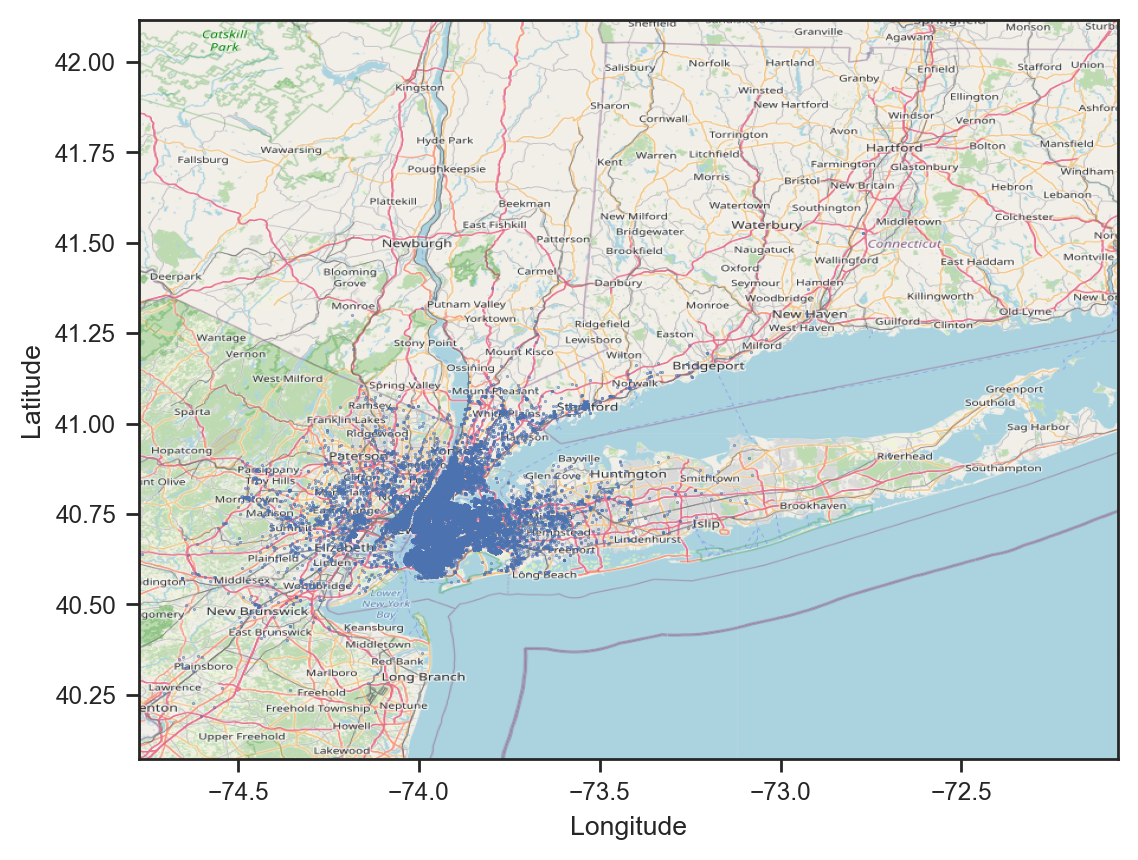

In [1639]:
ny_plotter.plot_on_map(longitude, latitude)

Machine learning algorithms will be a bit slow because we have over half a million data points.
So, as you develop your code, use only 50K observations.
Once you have a stable version of your code, modify the following code segment to use the entire dataset.

In [1640]:
p1_train_data = location_data.__array__()

## Part A - Splitting New York City into Subregions

Suppose you are assigned to split New York City into operating subregions with equal demand.
When a pickup is requested in each subregion, only the drivers in that region are called.
Note that this can become a challenging problem very quickly.
We are not looking for the best possible answer here.
We are looking for a data-informed heuristic solution that is good enough.

Do (at least) the following:
+ Use Kmeans clustering on the pickup data with different numbers of clusters;
+ Visualize the labels of the clusters on the map using different colors (see the hands-on activities);
+ Visualize the centers of the discovered Kmeans clusters (in red color);
+ Use common sense, e.g., ensure there are enough clusters so no region crosses the water. If it is impossible to get perfect results simply by Kmeans, feel free to ignore a small number of outliers as they could be handled manually;
+ Use [MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans), which is a much faster version of Kmeans suitable for large datasets (>10K observations);

Answer with as many text and code blocks as you like below.

In [1641]:
def map_cluster_plot(plotter: MapPlotter, model: MiniBatchKMeans, data: NDArray):
    plotter.plot_on_map(data[:, 0], data[:, 1], c=model.predict(data))
    x = model.cluster_centers_[:, 0]
    y = model.cluster_centers_[:, 1]
    plt.scatter(x, y, c="red", marker="x", s=10, label="centers")
    plt.title(f"KMeans clustering with {model.n_clusters} clusters")
    plt.legend()

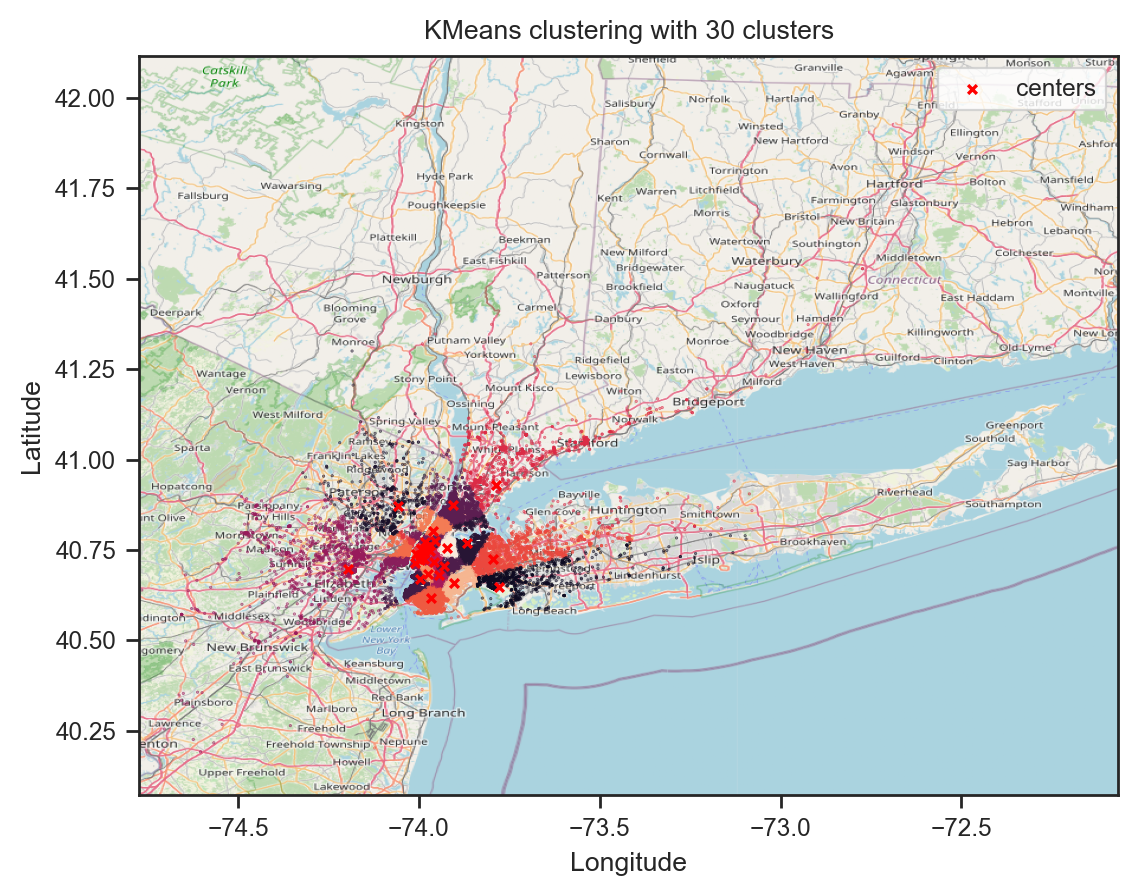

In [1642]:
n_clusters = 30
model = MiniBatchKMeans(n_clusters=n_clusters, n_init="auto").fit(p1_train_data)
map_cluster_plot(ny_plotter, model, p1_train_data)

## Part B - Create a Stochastic Model of Pickups

One of the key ingredients for a more sophisticated approach to optimizing the operations of Uber is the construction of a stochastic model of the demand for pickups.
The ideal model for this problem is the [Poisson Point Process](https://en.wikipedia.org/wiki/Poisson_point_process).
However, we will do something more straightforward, using the Gaussian mixture model and a Poisson random variable.
The model will not have a time component, but it will allow us to sample the number and locations of pickups during a typical month.
We will guide you through the process of constructing this model.

### Subpart B.I - Random variable capturing the number of monthly pickups

Find the rate of monthly pickups (ignore the fact that months may differ by a few days) and use it to define a Poisson random variable corresponding to the monthly number of pickups.
Use ``scipy.stats.poisson`` to initialize this random variable. Sample from it 10,000 times and plot the histogram of the samples to get a feeling about the corresponding probability mass function.

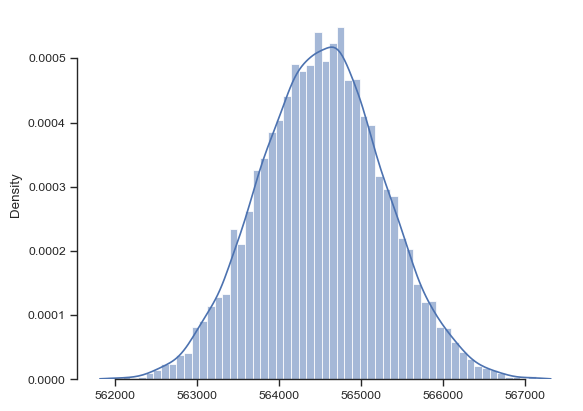

In [1643]:
monthly_pickups = len(p1_data)
pickups_rv = st.poisson(monthly_pickups)
samples = pickups_rv.rvs(10_000)
sns.histplot(samples, stat="density", kde=True)
sns.despine(trim=True)

In [1644]:
model = GaussianMixture(n_components=n_clusters).fit(p1_train_data)

### Subpart B.II - Sample some random monthly pickup numbers

Now that you have a model that gives you the number of pickups and a model that allows you to sample a pickup location, sample five different datasets (number of pickups and location of each pick) from the combined model and visualize them on the New York map.

**Hint:** Don't get obsessed with making the model perfect. It's okay if a few of the pickups are on water.

/Users/matthansen/.pyenv/versions/3.12.2/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/matthansen/.pyenv/versions/3.12.2/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


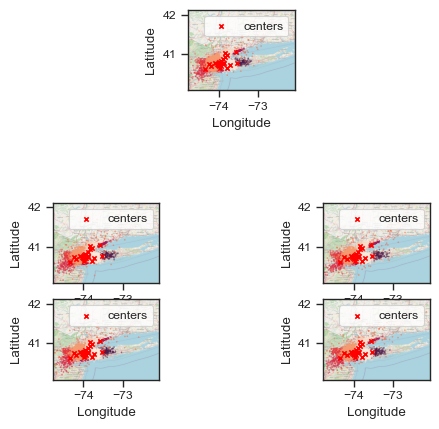

In [1645]:
class UberSample:
    def __init__(self):
        self.n_pickups = pickups_rv.rvs()
        self.samples, self.labels = model.sample(self.n_pickups)

    def plot(self, plotter: MapPlotter, ax: Axes):
        plotter.plot_on_map(self.samples[:, 0], self.samples[:, 1], ax, c=self.labels)
        x = model.means_[:, 0]
        y = model.means_[:, 1]
        ax.scatter(x, y, c="red", marker="x", s=10, label="centers")
        ax.legend()


fig = plt.figure()
gs = fig.add_gridspec(4, 2)
ax1 = fig.add_subplot(gs[:1, :])
ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[2, 1])
ax4 = fig.add_subplot(gs[3, 0])
ax5 = fig.add_subplot(gs[3, 1])
axs = [ax1, ax2, ax3, ax4, ax5]
for ax in axs:
    sample_data = UberSample()
    sample_data.plot(ny_plotter, ax)

# Problem 2 - Counting Celestial Objects

Consider this picture of a patch of sky taken by the [Hubble Space Telescope](https://www.nasa.gov/mission_pages/hubble/story/index.html).

Let's download it so that you have it here:

In [1646]:
url = "https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/lecturebook/images/galaxies.png"
file_path = download(url)

This picture includes many galaxies but also some stars.
We will create a machine-learning model capable of counting the number of objects in such images.
Our model will not be able to differentiate between the different types of objects and will not be very accurate. Still, it does form the basis of more sophisticated approaches.
The idea is as follows:
+ Convert the picture to points sampled according to the intensity of light.
+ Apply Gaussian mixture on the resulting points.
+ Use the Bayesian Information Criterion to identify the number of components in the picture.
+ Associate the number of components with the actual number of celestial objects.

I will set you up with the first step. You will have to do the last three.

We are going to load the image with the [Python Imaging Library (PIL)](https://en.wikipedia.org/wiki/Python_Imaging_Library), which allows us to apply a few basic transformations to the image:

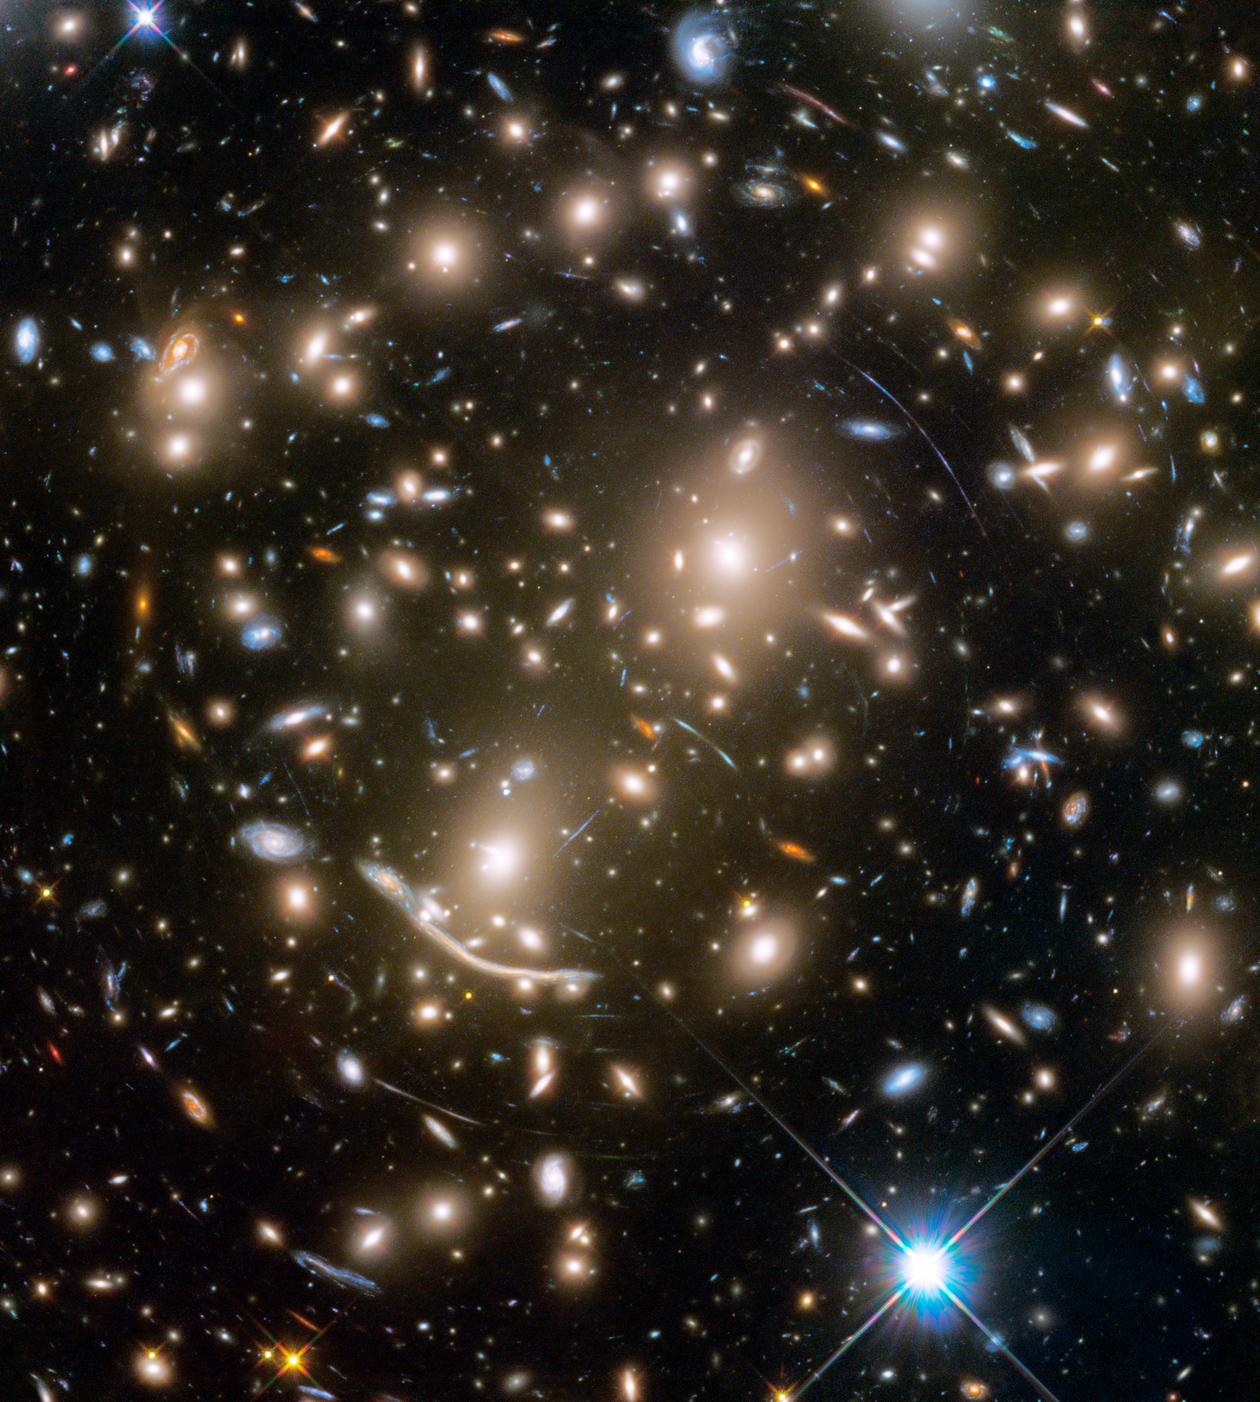

In [1647]:
hubble_image = Image.open(file_path)
hubble_image

Now, we are going to convert it to grayscale and crop it to make the problem a little bit easier:

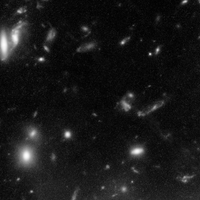

In [1662]:
image = hubble_image.convert("L").crop((100, 100, 300, 300))
image

Remember that black-and white images are matrices:

In [1663]:
image_array = np.array(image)
image_array

array([[ 7, 11, 11, ..., 28, 62, 88],
       [12, 12, 11, ..., 29, 47, 86],
       [18, 13, 11, ..., 24, 34, 87],
       ...,
       [24, 12, 15, ..., 43, 47, 40],
       [23, 12, 19, ..., 48, 49, 40],
       [18, 18, 23, ..., 50, 49, 41]], dtype=uint8)

The minimum number is $0$, corresponding to black, and the maximum is 255, corresponding to white.
Anything in between is some shade of gray.

Now, imagine that each pixel is associated with some coordinates.
Without loss of generality, let's assume that each pixel is some coordinate in $[0,1]^2$.
We will loop over each pixel and sample its coordinates in a way that increases with increasing light intensity.
To achieve this, we will pass the intensity values of each pixel through a sigmoid with parameters that can be tuned.
Here is this sigmoid:

In [1664]:
def sigmoid(x: float, alpha: float, beta: float) -> float:
    return 1 / (1 + np.exp(-alpha * (x - beta)))

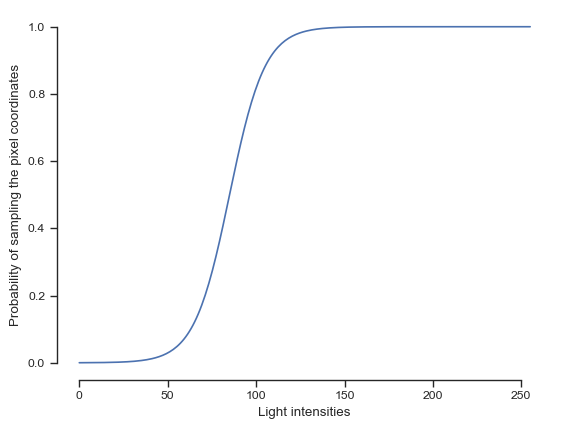

In [1665]:
intensities = np.linspace(0, 255, 255)
fig, ax = plt.subplots()
ax.plot(intensities, sigmoid(intensities, alpha=0.1, beta=255 / 3))
ax.set_xlabel("Light intensities")
ax.set_ylabel("Probability of sampling the pixel coordinates")
sns.despine(trim=True);

And here is the code that samples the pixel coordinates.
I am organizing it into a function because we may want to use it with different pictures:

In [1684]:
def sample_pixel_coords(image: Image, scale: float, offset: float):
    """
    Samples pixel coordinates based on a probability defined as the sigmoid of the intensity.
    """
    image_array = np.array(image)
    x = np.linspace(0, 1, image_array.shape[0])
    y = np.linspace(0, 1, image_array.shape[1])
    X, Y = np.meshgrid(x, y)
    coords = []
    for i in range(image_array.shape[1]):
        for j in range(image_array.shape[0]):
            prob = sigmoid(image_array[j, i], scale, offset)
            u = np.random.rand()
            if u <= prob:
                coords.append((Y[i, j], X[-i - 1, -j - 1]))
    coords = np.array(coords)
    return coords

Let's test it:

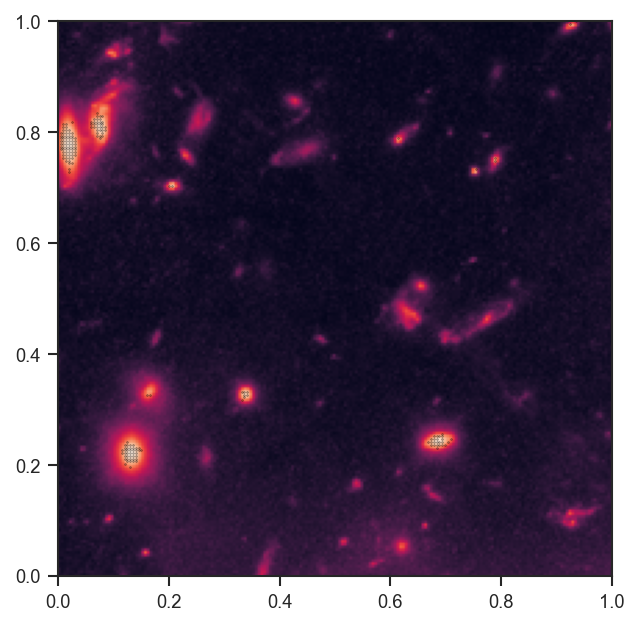

In [1686]:
coords = sample_pixel_coords(image, scale=0.1, offset=200)
fig, ax = plt.subplots(dpi=150)
ax.imshow(image, extent=((0, 1, 0, 1)), zorder=0)
ax.scatter(coords[:, 0], coords[:, 1], zorder=1, alpha=0.5, c="black", s=0.1);

Note that playing with $\alpha$ and $\beta$ makes the whole thing more or less sensitive to the light intensity.

Complete the following function:

In [ ]:
def count_galaxies(
    image: Image,
    scale: float,
    offset: float,
    component_limits: tuple[int, int] = (1, 50),
):
    """Count objects in image using GaussianMixture model."""
    coords = sample_pixel_coords(image, scale, offset)
    best_bic = np.inf
    for i in range(*component_limits):
        model = GaussianMixture(n_components=i, n_init="auto").fit(coords)
        bic = model.bic(coords)
        if bic < best_bic:
            best_bic = bic
            best_model = model
            best_nc = i
    return best_nc, best_model, coords

Once you have completed the code, try out the following images.
Feel free to play with $\alpha$ and $\beta$ to improve the performance.
**Do not try to make a perfect model. We would have to go beyond the Gaussian mixture model to do so. This is just a homework problem.**

Here is a helpful function that you can use to visualize the results:

In [ ]:
def visualize_counts(
    image: Image, galaxies: int, model: GaussianMixture, coords: NDArray
):
    """Visualize the counts."""
    fig, ax = plt.subplots(dpi=150)
    ax.imshow(image, extent=((0, 1, 0, 1)))
    for i in range(model.means_.shape[0]):
        ax.plot(
            model.means_[i, 0],
            model.means_[i, 1],
            "rx",
            markersize=(10.0 * model.weights_.shape[0] * model.weights_[i]),
        )
    ax.scatter(coords[:, 0], coords[:, 1], zorder=1, alpha=0.5, c="b", s=1)
    ax.set_title("Counted {0:d} objects!".format(galaxies))

Here is how to use it:

In [ ]:
galaxies, model, coords = count_galaxies(image, scale=1.0, offset=200)
visualize_counts(image, galaxies, model, coords)

TypeError: 'NotImplementedType' object is not callable

Try this image:

In [ ]:
image = hubble_image.convert("L").crop((200, 200, 400, 400))
objs, model, locs = count_galaxies(image, scale=0.1, offset=250)
visualize_counts(image, objs, model, locs)

And this one:

In [ ]:
image = hubble_image.convert("L").crop((300, 300, 500, 500))
objs, model, locs = count_galaxies(image, scale=0.1, offset=250)
visualize_counts(image, objs, model, locs)

# Problem 3 - Filtering of an Oscillator with Damping

Assume that you are dealing with a one-degree-of-freedom system which follows the equation:

$$
\ddot{x} + 2\zeta \omega_0 \dot{x} + \omega^2_0 x = u_0 \cos(\omega t),
$$

where $x = x(t)$ is the generalized coordinate of the oscillator at time $t$, and the parameters $\zeta$, $\omega_0$, $u_0$, and $\omega$ are known to you (we will give them specific values later).
Furthermore, assume that you are making noisy observations of the *absolute acceleration* at discrete timesteps $\Delta t$ (also known):

$$
y_j = \ddot{x}(j\Delta t)-u_0 \cos(\omega t)+w_j,
$$

for $j=1,\dots,n$, where $w_j \sim N(0, \sigma^2)$ with $\sigma^2$ also known.
Finally, assume that the initial conditions for the position and the velocity (you need both to get a unique solution) are given by:

$$
x_0 = x(0) \sim N(0, \sigma_x^2),
$$

and

$$
v_0 = \dot{x} \sim N(0, \sigma_v^2).
$$

Of course, assume that $\sigma_x^2$ and $\sigma_v^2$ are specific numbers we will specify below.

Before we go over the questions, let's write code that generates the actual trajectory of the system at some random initial conditions and some observations.
We will use the code to generate a synthetic dataset with known ground truth, which you will use in your filtering analysis.

The first step we need to do is to turn the problem into a first-order differential equation.
We set:

$$
\mathbf{x} = 
\begin{bmatrix}
x\\
\dot{x}
\end{bmatrix}.
$$

Assuming $\mathbf{x} = (x_1,x_2)$, then the dynamics are described by:

$$
\dot{\mathbf{x}} = 
\begin{bmatrix}
\dot{x}\\
\ddot{x}
\end{bmatrix}
= 
\begin{bmatrix}
x_2\\
-2\zeta \omega_0 \dot{x} - \omega^2_0 x + u_0 \cos(\omega t)
\end{bmatrix}
=
\begin{bmatrix}
x_2\\
-2\zeta \omega_0 x_2 - \omega^2_0 x_1 + u_0 \cos(\omega t)
\end{bmatrix}
$$

The initial conditions are of course, just:

$$
\mathbf{x}_0 =
\begin{bmatrix}
x_0\\
v_0
\end{bmatrix}.
$$

This first-order system can solved using [scipy.integrate.solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp).
Here is how:

In [ ]:
# You need to define the right hand side of the equation
def rhs(t, x, omega0, zeta, u0, omega):
    """Return the right hand side of the dynamical system.

    Arguments
    t       -    Time
    x       -    The state
    omega0  -    Natural frequency
    zeta    -    Dumping factor (0<=zeta)
    u0      -    External force amplitude
    omega   -    Excitation frequency
    """
    res = np.ndarray((2,))
    res[0] = x[1]
    res[1] = -2.0 * zeta * omega0 * x[1] - omega0**2 * x[0] + u0 * np.cos(omega * t)
    return res

And here is how you solve it for given initial conditions and parameters:

In [ ]:
# Initial conditions
x0 = np.array([0.0, 1.0])
# Natural frequency
omega0 = 2.0
# Dumping factor
zeta = 0.4
# External forcing amplitude
u0 = 0.5
# Excitation frequency
omega = 2.1
# Timestep
dt = 0.1
# The final time
final_time = 10.0
# The number of timesteps to get the final time
n_steps = int(final_time / dt)
# The times on which you want the solution
t_eval = np.linspace(0, final_time, n_steps)
# The solution
sol = solve_ivp(rhs, (0, final_time), x0, t_eval=t_eval, args=(omega0, zeta, u0, omega))

The solution is stored in the ``sol`` variable:

In [ ]:
sol.y.shape

The shape of ``sol.y`` is (2, 100), which means that we have 100 timesteps and two variables (position and velocity).
Let's plot the position and the velocity:

In [ ]:
fig, ax = plt.subplots(dpi=150)
ax.plot(t_eval, sol.y[0, :], label="Position")
ax.plot(t_eval, sol.y[1, :], label="Velocity")
ax.set_xlabel("$t$")
ax.set_ylabel("$x_i(t)$")
plt.legend(loc="best", frameon=False)
sns.despine(trim=True);

Let's now generate some synthetic observations of the acceleration with some given Gaussian noise.
To get the acceleration, you can do this:

In [ ]:
# Compute external excitation.
us = u0 * np.cos(omega * t_eval)
# Subtract us from \ddot{x}
true_acc = (
    np.array([rhs(t, x, omega0, zeta, u0, omega)[1] for (t, x) in zip(t_eval, sol.y.T)])
    - us
)

Let's add some noise:

In [ ]:
sigma_r = 0.2
observations = true_acc + sigma_r * np.random.randn(true_acc.shape[0])

fig, ax = plt.subplots(dpi=150)
ax.plot(t_eval, true_acc, label="Acceleration")
ax.plot(t_eval, observations, ".", label="Noisy observation of acceleration")
ax.set_xlabel("$t$")
ax.set_ylabel(r"$\ddot{x}(t)$")
plt.legend(loc="best", frameon=False)
sns.despine(trim=True);

Okay. Now, imagine that you only see the noisy observations of the acceleration.
The filtering goal is to recover the state of the underlying system (as well as its acceleration).
I am going to guide you through the steps you need to follow.

## Part A - Discretize time (Transitions)

Use the Euler time discretization scheme to turn the continuous dynamical system into a discrete-time dynamical system like this:

$$
\mathbf{x}_{j+1} = \mathbf{A}\mathbf{x}_j + Bu_j + \mathbf{z}_j,
$$

where

$$
\mathbf{x}_j = \mathbf{x}(j\Delta t),
$$

$$
u_j = u(j\Delta t),
$$

and $\mathbf{z}_j$ is properly chosen process noise term.
You should derive and provide mathematical expressions for the following:
+ The $2 \times 2$ transition matrix $\mathbf{A}$.
+ The $2 \times 1$ control "matrix" $B$.
+ The process covariance $\mathbf{Q}$. For the process covariance, you may choose your values by hand.

**Answer:**

In [ ]:
# You should be using the parameters dt, omega0, zeta, etc.
# from above
A = np.array([[REPLACE_ME, REPLACE_ME], [REPLACE_ME, REPLACE_ME]])

B = np.array([[REPLACE_ME], [REPLACE_ME]])

Q = np.array([[REPLACE_ME, 0.0], [0.0, REPLACE_ME]])

## Part B - Discretize time (Emissions)

Establish the map that takes you from the states to the accelerations at each timestep.
That is, specify:

$$
y_j = \mathbf{C}\mathbf{x}_j + w_j,
$$

where

$$
y_j = \ddot{x}(j\Delta t)-u_0 \cos(\omega t)+w_j,
$$

and $w_j$ is a measurement noise.
You should derive and provide mathematical expressions for the following:
+ The $1 \times 2$ emission matrix $\mathbf{C}$.
+ The $1 \times 1$ covariance "matrix" $R$ of the measurement noise.

**Answer:**

In [ ]:
C = np.array([[REPLACE_ME, REPLACE_ME]])

R = np.array([[REPLACE_ME]])

## Part C - Apply the Kalman filter

Use ``FilterPy`` (see the hands-on activity of Lecture 20) to infer the unobserved states given the noisy observations of the accelerations.
Plot time-evolving 95% credible intervals for the position and the velocity along with the true unobserved values of these quantities (in two separate plots).

In [ ]:
# Your answer here (as many code and text blocks as you want)

## Part D - Quantify and visualize your uncertainty about the actual acceleration value

Use standard uncertainty propagation techniques to quantify your epistemic uncertainty about the true acceleration value.
You will have to use the inferred states of the system and the dynamical model.
This can be done either analytically or by Monte Carlo. It's your choice.
In any case, plot time-evolving 95% credible intervals for the acceleration (epistemic only), the true unobserved values, and the noisy measurements.

In [ ]:
# Your answer here (as many code and text blocks as you want)